### Import Libraries

In [1]:
import math
import os
import numpy as np
import time
import matplotlib.pyplot as plt
import plotly.io as pio
import plotly.express as px
import pandas as pd
import itertools
import pickle

pio.renderers.default = 'iframe'

### Define Paths

In [2]:
research_dir = r"D:/school/research"
code_dir = os.path.join(research_dir, "code")
p2_dir = os.path.join(code_dir, "paper_two_code")
model_dir = os.path.join(p2_dir, "models")
metrics_dir = os.path.join(p2_dir, "metrics")
mmmetrics_dir = os.path.join(metrics_dir, "multimodal")
data_dir = os.path.join(research_dir, "data")
dhcp_rel2 = os.path.join(data_dir, "dhcp_rel2")
processed_dir = os.path.join(dhcp_rel2, "processed")
volume_dir = os.path.join(processed_dir, "volumes")
l1_dir = os.path.join(volume_dir, "l1")
l5_dir = os.path.join(volume_dir, "l5")

### Read Metrics

In [3]:
std_bands = [
    {
        "range": "-inf to -4",
        "low": -np.inf,
        "high": -4
    },
    {
        "range": "-4 to -3",
        "low": -4,
        "high": -3
    },
    {
        "range": "-3 to -2",
        "low": -3,
        "high": -2
    },
    {
        "range": "2 to 3",
        "low": 2,
        "high": 3
    },
    {
        "range": "3 to 4",
        "low": 3,
        "high": 4
    },
    {
        "range": "4 to inf",
        "low": 4,
        "high": np.inf
    }
]

model_versions = {
    "t1_t2_{}": "Multimodal Combined",
    "multimodal_{}_t1": "Multimodal T1",
    "t1_{}": "T1 Only",
    "multimodal_{}_t2": "Multimodal T2",
    "t2_{}": "T2 Only"
}

run_names = ["train", "val", "test"]

### ROC

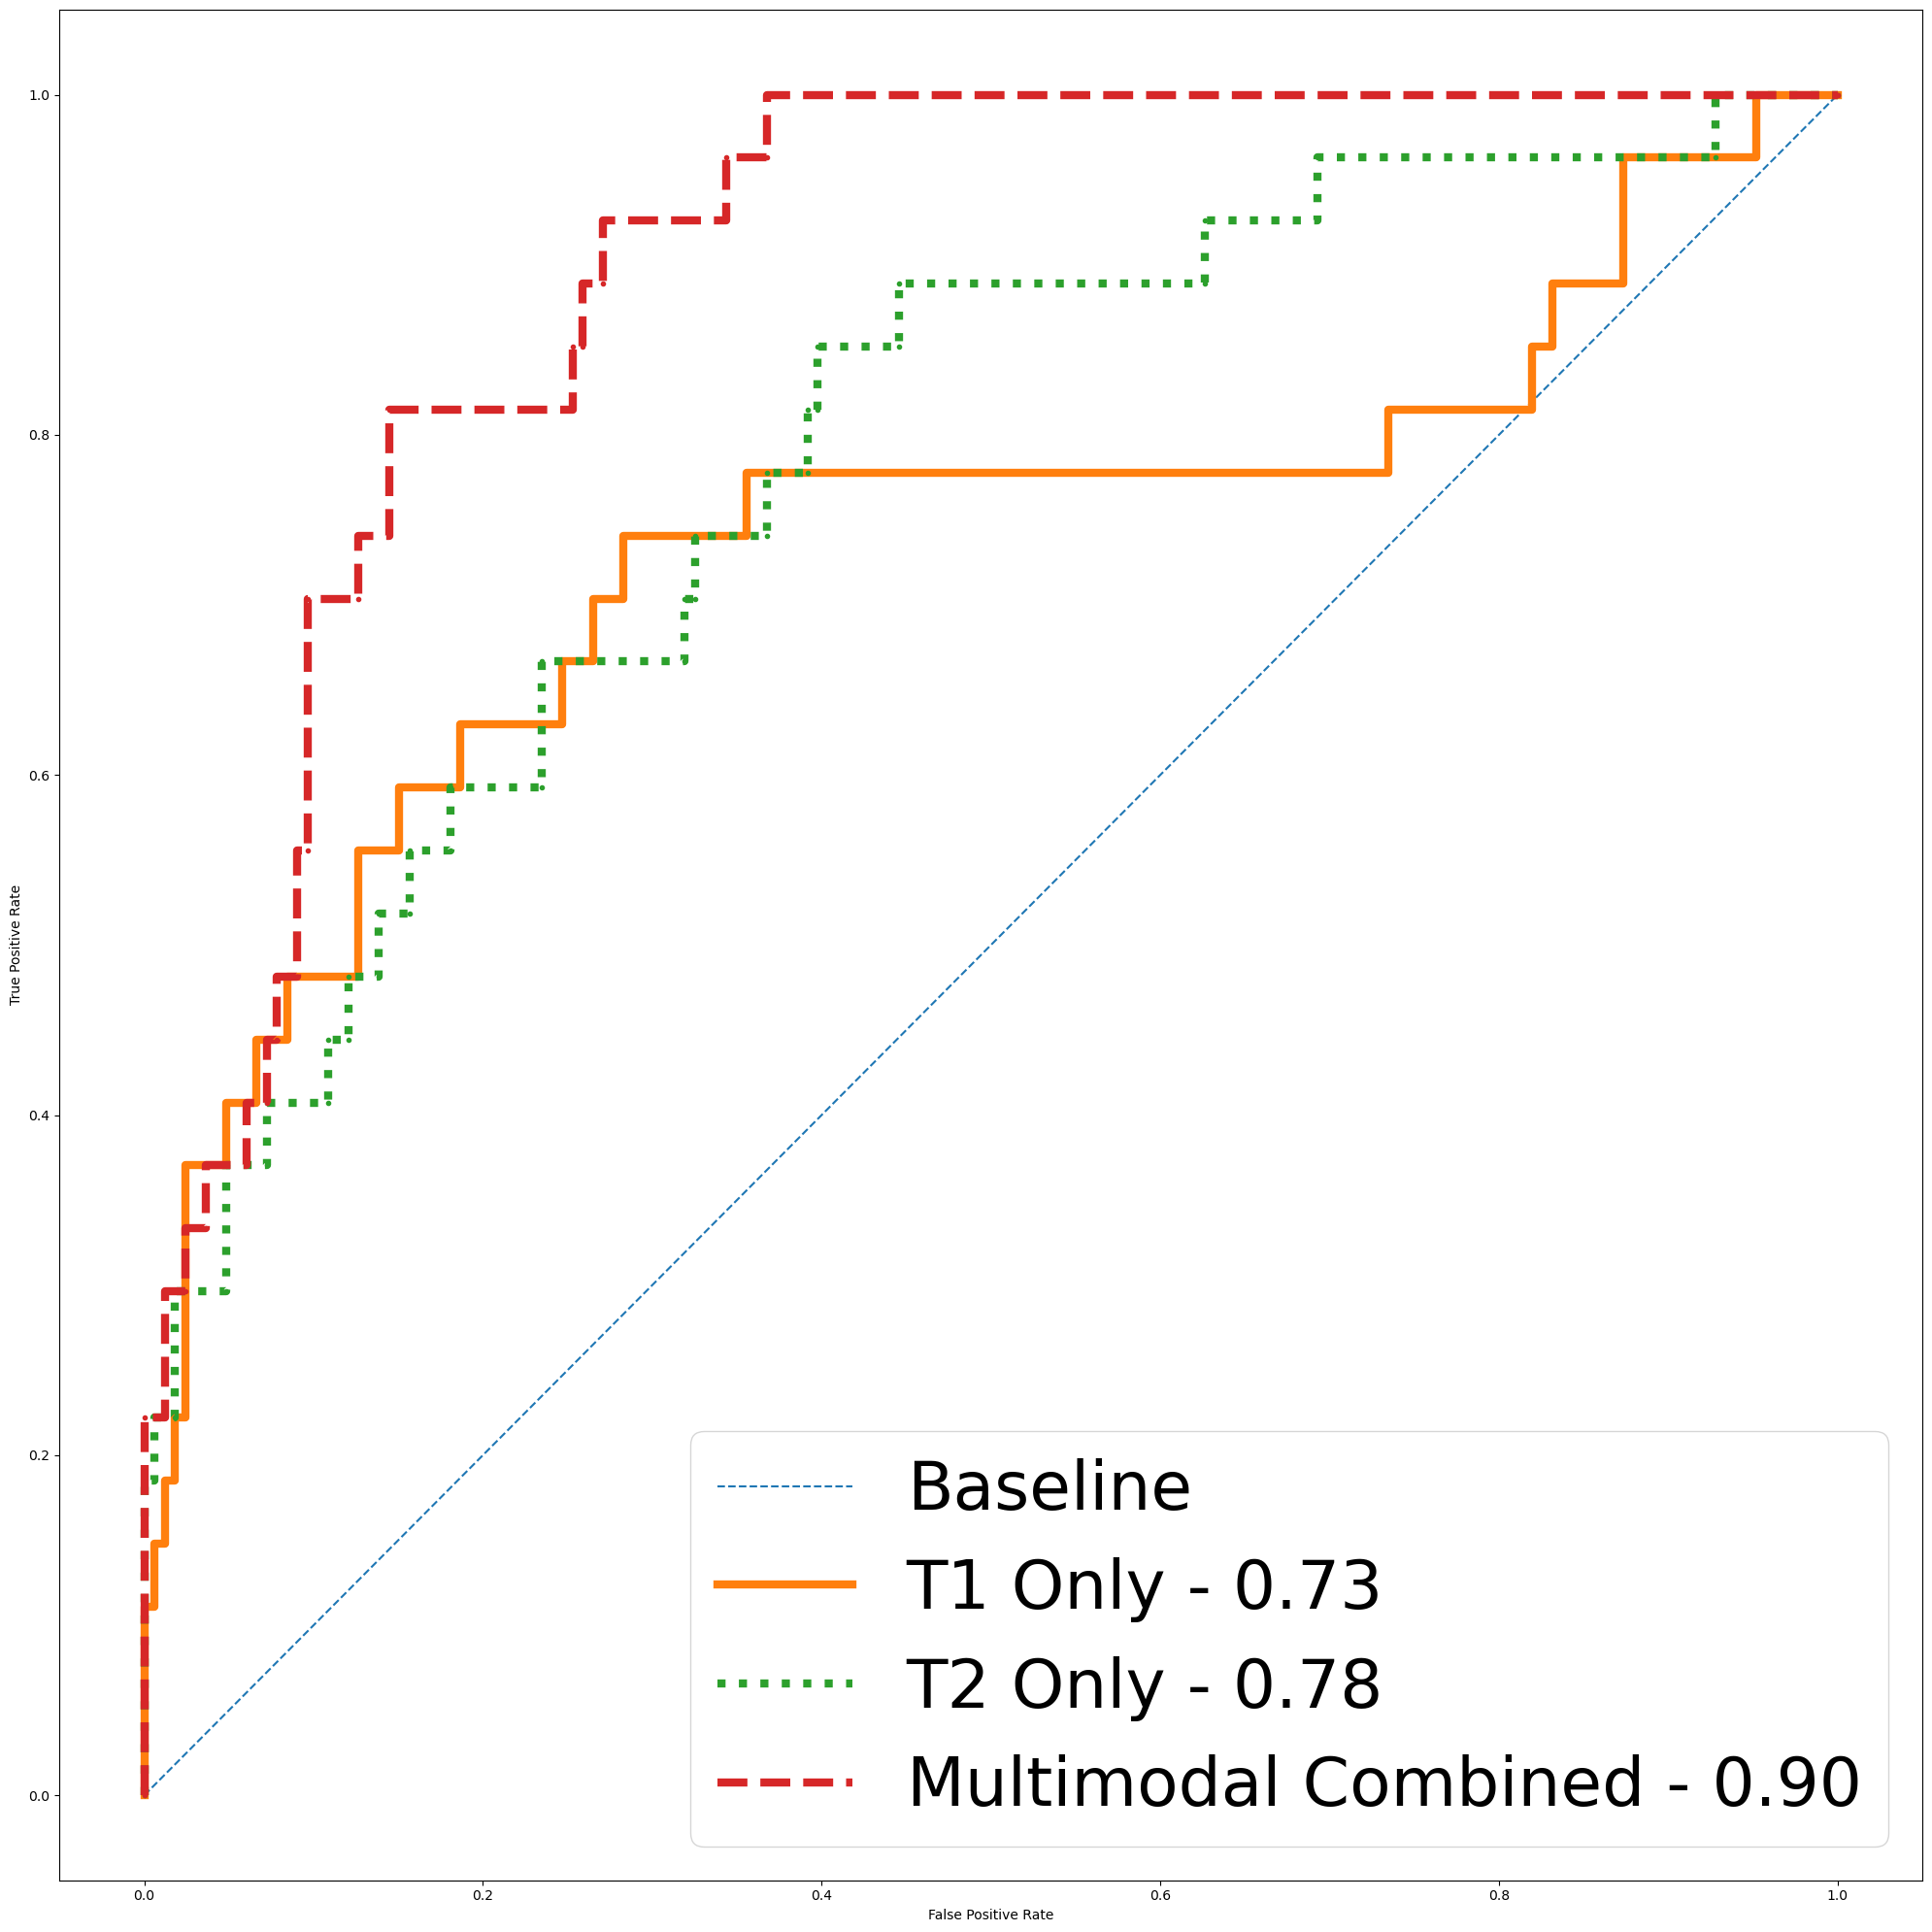

In [71]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score


def get_roc(x, y):
    ns_probs = [0 for _ in range(len(y))]
    ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y, x)
    auc = roc_auc_score(y, x)
    
    return lr_fpr, lr_tpr, auc

fig, ax = plt.subplots(figsize=(20, 20))

y = [round(np.random.rand()) for x in range(193)]
ns_probs = [0 for _ in range(len(y))]
ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Baseline')

line_styles = ['solid', 'dotted', 'dashed', 'dashdot']

# get ROC's for each model
counter = 0
for name in ["T1 Only", "T2 Only", "Multimodal Combined"]:
    train_loss = loss_df[(loss_df["model_name"] == name) & (loss_df["run_name"] == "Train")]["loss"]
    test_loss = loss_df[(loss_df["model_name"] == name) & (loss_df["run_name"] == "Test")]["loss"]

    x =list(train_loss)
    x.extend(np.array(test_loss))
    x = np.array(x).reshape(-1, 1)
    train_classes = [0] * len(train_loss)
    y = train_classes.copy()
    y.extend([1] * len(test_loss))

    lr_fpr, lr_tpr, auc = get_roc(x,y)
    plt.plot(lr_fpr, lr_tpr, marker='.', label=name + " - {:.2f}".format(auc), linestyle=line_styles[counter], linewidth=6)
    counter += 1

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4, prop={'size': 50})

plt.tight_layout()
plt.savefig('figures/multimodal_roc.png')

### Losses

In [4]:
### overall losses
losses = []
runs = []
models = []
for model in model_versions.keys():
    for run in run_names:
        loss_path = os.path.join(mmmetrics_dir, f"{model.format(run)}_losses.npy")

        loss = np.load(loss_path)
        
        losses.extend(loss)
        runs.extend([run.capitalize() for x in range(0, len(loss))])
        models.extend([model_versions[model] for x in range(0, len(loss))])
    
loss_df = pd.DataFrame({"run_name": runs, "model_name": models, "loss": losses})

fig = px.box(
    loss_df,
    x="model_name",
    y="loss",
    color="run_name",
    color_discrete_map={
        "Train": "green",
        "Val": "orange",
        "Test": "red"
    }
)
fig.update_traces(quartilemethod="exclusive")
fig.update_layout(
    xaxis_title="Model Version",
    yaxis_title="Loss (MSE)",
    legend_title="Run Name",
    font=dict(
        family="Arial",
        size=18
    ),
    yaxis = dict(
        tickfont = dict(size=20)
    ),
    xaxis = dict(
        tickfont = dict(size=30)
    )
)
fig.write_image("figures/multimodal_losses.png", width=2000, height=500)

### Clusters

In [32]:
### overall losses
clusters = []
runs = []
models = []
for model in model_versions.keys():
    for run in run_names:
        cluster_path = os.path.join(mmmetrics_dir, f"{model.format(run)}_clusters.npy")
        cluster = np.load(cluster_path, allow_pickle=True)
        cluster = [np.mean(x) for x in cluster]
#         cluster = list(itertools.chain.from_iterable(np.load(cluster_path, allow_pickle=True)))
        
        clusters.extend(cluster)
        runs.extend([run.capitalize() for x in range(0, len(cluster))])
        models.extend([model_versions[model] for x in range(0, len(cluster))])
    
cluster_df = pd.DataFrame({"run_name": runs, "model_name": models, "clusters": clusters})

fig = px.box(
    cluster_df,
    x="model_name",
    y="clusters",
    color="run_name",
    color_discrete_map={
        "Train": "green",
        "Val": "orange",
        "Test": "red"
    }
)
fig.update_traces(quartilemethod="exclusive") 
fig.update_layout(
    xaxis_title="Model Version",
    yaxis_title="Cluster Size (Pixels)",
    legend_title="Run Name",
    font=dict(
        family="Arial",
        size=18
    ),
    yaxis = dict(
        tickfont = dict(size=20)
    ),
    xaxis = dict(
        tickfont = dict(size=30)
    )
)
fig.write_image("figures/multimodal_clusters.png", width=2000, height=500)

### Banded Metrics

In [33]:
%%time

total_pixels = 256**3
pixels = []
pixel_runs = []
pixel_models = []
pixel_band = []

clusters = []
cluster_runs = []
cluster_models = []
cluster_band = []

for model in model_versions.keys():
    for run in run_names:
        band_path = os.path.join(mmmetrics_dir, f"{model.format(run)}_banded_metrics.pkl")
        with open(band_path, "rb") as f:
            bands = pickle.load(f)
        
        # Get pixel percents
        for band in [x["range"] for x in std_bands]:
            pix = np.mean([(x / total_pixels) * 100 for x in bands[f"{band} pixels"]])
            pixels.append(pix)
            pixel_runs.append(run.capitalize())
            pixel_models.append(model_versions[model])
            pixel_band.append(band)
        
        # Get average clusters
        for band in [x["range"] for x in std_bands]:
            clust = np.mean([np.mean(x) for x in bands[f"{band} clusters"]])
            clusters.append(clust)
        

pixel_band_df = pd.DataFrame({
    "Model": pixel_models,
    "Run": pixel_runs,
    "Band": pixel_band,
    "Pixels Percentage": pixels,
    "Average Cluster": clusters
})

C:\compute\envs\torch\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning:

Mean of empty slice.

C:\compute\envs\torch\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning:

invalid value encountered in double_scalars



CPU times: total: 16.9 s
Wall time: 16.9 s


In [36]:
fig = px.bar(
    pixel_band_df,
    x="Run",
    y="Pixels Percentage",
    color="Band",
    facet_col="Model",
    color_discrete_map={
        "-inf to -4": "#003d9e",
        "-4 to -3": "#3272d9",
        "-3 to -2": "#80acf2",
        "2 to 3": "#f28080",
        "3 to 4": "#d14343",
        "4 to inf": "#a10606"
    }
)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.for_each_annotation(lambda a: a.update(font=dict(size=28)))
fig.update_layout(
    font=dict(
        family="Arial",
        size=18
    )
)
fig
fig.show()
fig.write_image("figures/multimodal_banded_losses.png", width=2000, height=500)

In [37]:
fig = px.bar(
    pixel_band_df,
    x="Run",
    y="Average Cluster",
    color="Band",
    facet_col="Model",
    color_discrete_map={
        "-inf to -4": "#003d9e",
        "-4 to -3": "#3272d9",
        "-3 to -2": "#80acf2",
        "2 to 3": "#f28080",
        "3 to 4": "#d14343",
        "4 to inf": "#a10606"
    }
)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.for_each_annotation(lambda a: a.update(font=dict(size=28)))
fig.update_layout(
    font=dict(
        family="Arial",
        size=18
    )
)
fig.show()
fig.write_image("figures/multimodal_banded_clusters.png", width=2000, height=500)

In [20]:
fig = px.bar(
    pixel_band_df[~pixel_band_df['Band'].str.contains("-")],
    x="Run",
    y="Pixels Percentage",
    color="Band",
    facet_col="Model",
    color_discrete_map={
        "-inf to -4": "#003d9e",
        "-4 to -3": "#3272d9",
        "-3 to -2": "#80acf2",
        "2 to 3": "#f28080",
        "3 to 4": "#d14343",
        "4 to inf": "#a10606"
    }
)
fig.update_layout(
    font=dict(
        family="Arial",
        size=18
    )
)
fig.show()


In [23]:
fig = px.bar(
    pixel_band_df[pixel_band_df['Band'].str.contains("-")],
    x="Run",
    y="Pixels Percentage",
    color="Band",
    facet_col="Model",
    color_discrete_map={
        "-inf to -4": "#003d9e",
        "-4 to -3": "#3272d9",
        "-3 to -2": "#80acf2",
        "2 to 3": "#f28080",
        "3 to 4": "#d14343",
        "4 to inf": "#a10606"
    }
)
fig.update_layout(
    font=dict(
        family="Arial",
        size=18
    )
)
fig.show()

In [24]:
fig = px.bar(
    pixel_band_df[pixel_band_df['Band'].str.contains("-")],
    x="Run",
    y="Average Cluster",
    color="Band",
    facet_col="Model",
    color_discrete_map={
        "-inf to -4": "#003d9e",
        "-4 to -3": "#3272d9",
        "-3 to -2": "#80acf2",
        "2 to 3": "#f28080",
        "3 to 4": "#d14343",
        "4 to inf": "#a10606"
    }
)
fig.update_layout(
    font=dict(
        family="Arial",
        size=18
    )
)
fig.show()

In [25]:
fig = px.bar(
    pixel_band_df[~pixel_band_df['Band'].str.contains("-")],
    x="Run",
    y="Average Cluster",
    color="Band",
    facet_col="Model",
    color_discrete_map={
        "-inf to -4": "#003d9e",
        "-4 to -3": "#3272d9",
        "-3 to -2": "#80acf2",
        "2 to 3": "#f28080",
        "3 to 4": "#d14343",
        "4 to inf": "#a10606"
    }
)
fig.update_layout(
    font=dict(
        family="Arial",
        size=18
    )
)
fig.show()